Have you ever tried to use a cycle share program? Often, it's a race to the docking station which the app is showing as having available bikes. Being data-savy, I want to utilise publicly available data to predict if a station in San Francisco is going to have a few bikes in some time.

In [8]:
# dependencies
!pip install folium 

import folium
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import timedelta
from datetime import datetime
from folium.plugins import HeatMap
from google.cloud import bigquery
import google.datalab.bigquery as bq
from random import randrange
from tensorflow.contrib import rnn

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The data

In [1]:
%%bq tables describe --name bigquery-public-data.san_francisco.bikeshare_stations

In [9]:
%%bq query --name stations_by_landmark

select stations.landmark as area, count(distinct stations.station_id) as cd from `bigquery-public-data.san_francisco.bikeshare_stations` stations
group by stations.landmark
order by cd desc

In [ ]:
%chart columns --data stations_by_landmark --fields area,cd
{
  "legend":{"position":"none"},
  "vAxis": {
    "title":"number of docking stations"
  },
  "hAxis": {
    "title": "location of docking station"
  }
}

We can see that most of the stations are in San Francisco, and there are a few more around other areas. Let's take a look at data from one station.

In [21]:
%%bq tables describe --name bigquery-public-data.san_francisco.bikeshare_status

In [ ]:
%%bq query --name station-91

SELECT 
    status.time
  , status.bikes_available
FROM `bigquery-public-data.san_francisco.bikeshare_stations` stations 
JOIN `bigquery-public-data.san_francisco.bikeshare_status` status on stations.station_id = status.station_id
where stations.station_id = 91
order by status.time

In [ ]:
%chart line --data station-91 --fields time,bikes_available
{
  "legend":{"position":"none"},
  "vAxis": {
    "title":"number of bikes available"
  },
  "hAxis": {
    "title": "time"
  }
}

Uh-oh - that time series is looking pretty short! Maybe it's just this station?

In [28]:
%%bq query

SELECT station_id, count(*) as cs from `bigquery-public-data.san_francisco.bikeshare_status` 
group by station_id
order by cs desc
limit 10
;

station_id,cs
6,1559598
5,1559598
7,1559598
16,1559597
11,1559597
12,1559597
13,1559597
27,1559597
9,1559597
10,1559597


In [31]:
%%bq query

SELECT min(time) as min_time, max(time) as max_time FROM `bigquery-public-data.san_francisco.bikeshare_status` status
join (
SELECT station_id, count(*) as cs from `bigquery-public-data.san_francisco.bikeshare_status` 
group by station_id
order by cs desc
limit 10) top_10 on top_10.station_id = status.station_id
;

f0_,f1_
2013-08-29 12:06:01,2016-08-31 23:58:59


In [33]:
%%bq query --name count_by_day
select extract(date from time) as date, count(*) as cs
from  `bigquery-public-data.san_francisco.bikeshare_status`
group by date

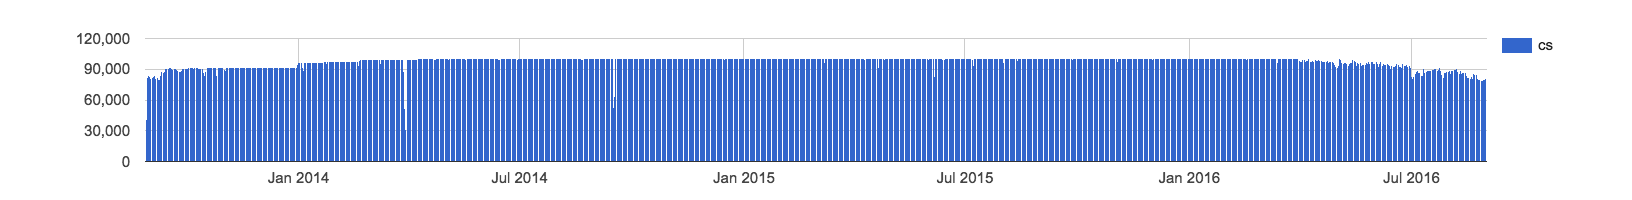

In [35]:
%chart columns --data count_by_day --fields date,cs
{"legend":{"position":"none"}}

In [36]:
%%bq query --name count_91_by_day
select extract(date from time) as date, count(*) as cs
from  `bigquery-public-data.san_francisco.bikeshare_status`
where station_id = 91
group by date

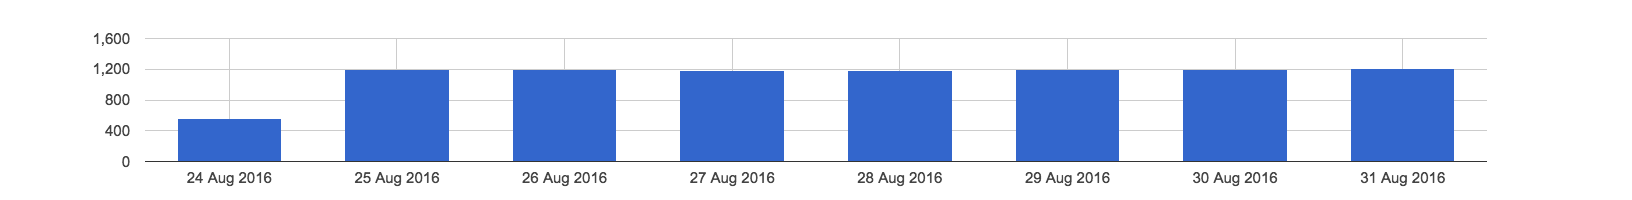

In [67]:
%chart columns --data count_91_by_day --fields date,cs
{"legend":{"position":"none"}}

In [38]:
%%bq query  --name count_6_by_day
select extract(date from time) as date, count(*) as cs
from  `bigquery-public-data.san_francisco.bikeshare_status`
where station_id = 6
group by date

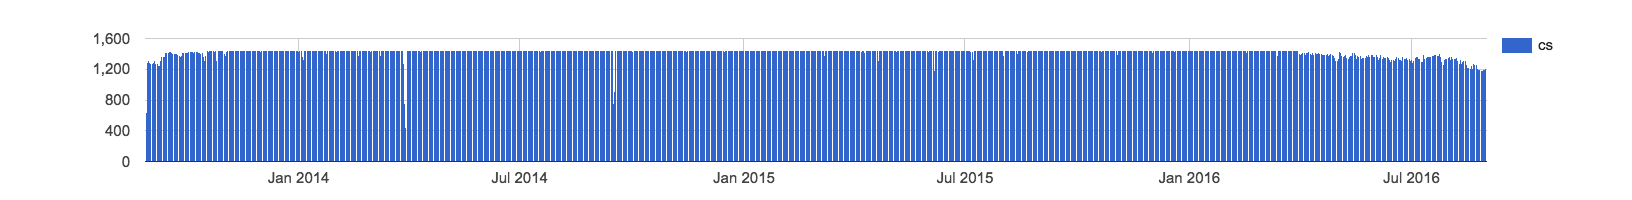

In [39]:
%chart columns --data count_6_by_day --fields date,cs
{"legend":{"position":"none"}}

Yep - the station we looked at doesn't have data for the whole time series. That could be a bit of a problem, depending on how widespread the issue is. 

In [46]:
%%bq query  --name date_distributions
select date_count
from (
select station_id, count(distinct extract(date from time)) as date_count
from  `bigquery-public-data.san_francisco.bikeshare_status`
group by station_id ) a

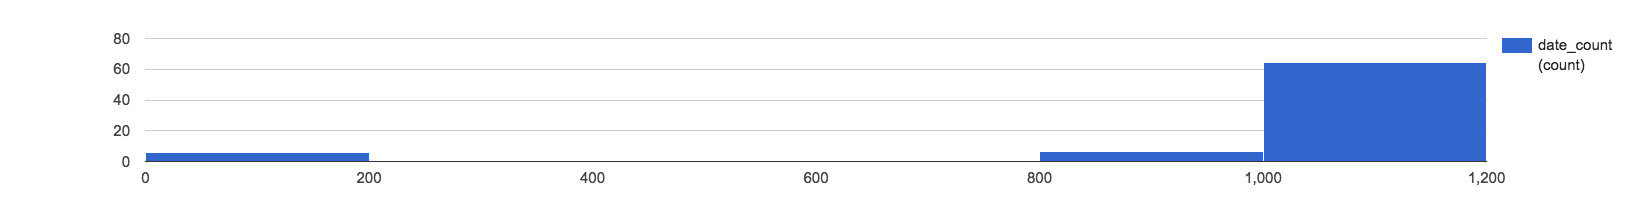

In [47]:
%chart histogram --data date_distributions --fields date_count
{"legend":{"position":"none"}}

Yes - station 91 is an outlier. Most of the stations in out data have a large number of distinct dates.

Let's have a look at the day of week seasonality in the data.

In [53]:
%%bq query --name available-by-dow
SELECT 
  extract(dayofweek from time) as dow, 
  sum(if(bikes_available < 2, 1, 0)) as not_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
group by dow
order by dow

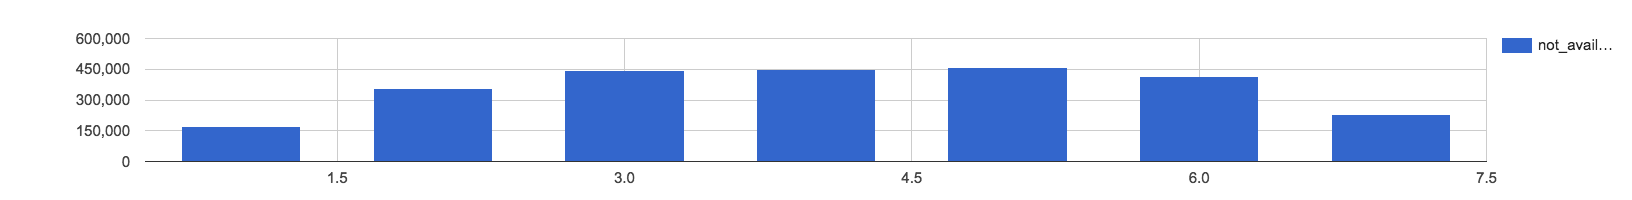

In [54]:
%chart columns --data available-by-dow --fields dow,not_available
{"legend":{"position":"none"}}

As expected, it's often harder to find a bike during the week, with higher availability during the weekend.

Let's have a look at the hourly data. First off, we should define a binary indicator to make things a little easier for us.

In [ ]:
%%bq query --name station-91-binary

SELECT 
   status.time
  , if(bikes_available > 2, 1, 0) as bikes_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status 
where status.station_id = 91
order by status.time

In [ ]:
%chart line --data station-91-binary --fields time,bikes_available

In [2]:
%%bq query

SELECT extract(hour from time) as hour, min(if(bikes_available > 2, 1, 0)) FROM `bigquery-public-data.san_francisco.bikeshare_status` status
where station_id = 91
group by hour
order by hour

hour,f0_
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,0


It looks like there are some hours which are more likely to have 0 availability in some areas. Let's see if that generalises. 

In [55]:
%%bq query --name available-by-hour

SELECT 
  extract(hour from time) as hour, 
  sum(if(bikes_available < 2, 1, 0)) as not_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
group by hour
order by hour

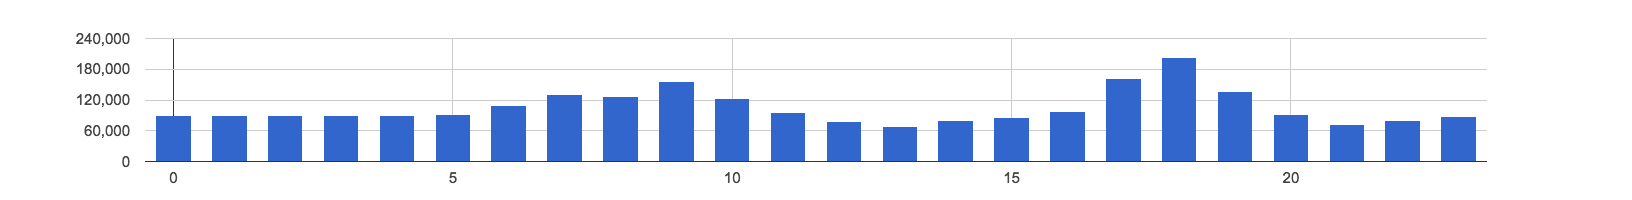

In [66]:
%chart columns --data available-by-hour --fields hour,not_available  
{"legend":{"position":"none"}}

OK, so at standard commuting times we do see an uptick in the number of docks which we couldn't visit. This seasonality could be a useful signal in our model. Now to investigate location of the docking station.

In [10]:
bq_data = bq.Query("""
select
  status.hour,
  stations.station_id,
  stations.latitude,
  stations.longitude,
  status.bikes_available
FROM `bigquery-public-data.san_francisco.bikeshare_stations` stations 
JOIN (
select 
   station_id,
   extract(hour from time) as hour,
   extract(dayofweek from time) as dow,
   sum(if(bikes_available > 2, 1, 0)) as bikes_available
   from `bigquery-public-data.san_francisco.bikeshare_status`
   group by station_id, hour
   having hour=18
) status on stations.station_id = status.station_id
""")
df = bq_data.execute(output_options=bq.QueryOutput.dataframe()).result()

In [11]:
max_amount = float(df['bikes_available'].max())
hmap = folium.Map(location=[37.333988, -121.894902], zoom_start=9)
hm_wide = HeatMap(zip(df.latitude.values, df.longitude.values, df.bikes_available.values), 
                  min_opacity=0.2,
                  max_val = max_amount,
                  radius=17, blur=15,
                  max_zoom=1,
                 )
hmap.add_child(hm_wide)

There seem to be some areas which have higher levels of availability than others at 18-19. Including latitude and longitude in most algorithms can lead to strange results, so we should keep an eye on this.

In [6]:
%%bq query --name dockcount_and_availability

select
  sum(not_available) as not_available,
  stations.dockcount
FROM `bigquery-public-data.san_francisco.bikeshare_stations` stations 
JOIN (
select 
   station_id,
  sum(if(bikes_available < 2, 1, 0)) as not_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
group by station_id
) status on stations.station_id = status.station_id
group by stations.dockcount

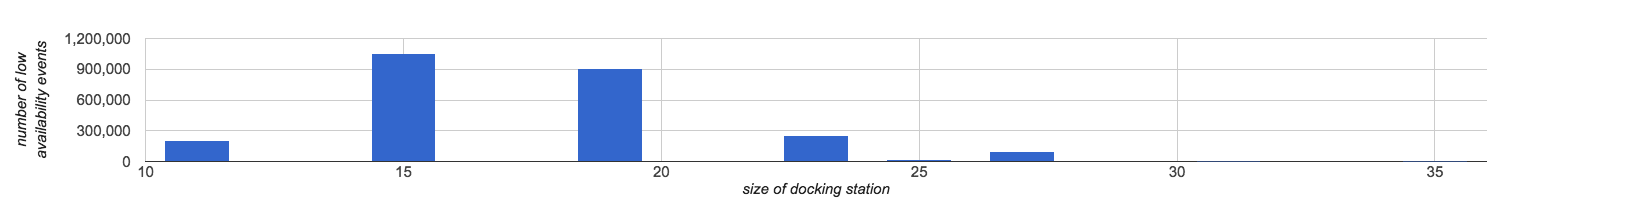

In [7]:
%chart columns --data dockcount_and_availability --fields dockcount,not_available
{
  "legend":{"position":"none"},
  "vAxis": {
    "title":"number of low availability events"
  },
  "hAxis": {
    "title": "size of docking station"
  }
}

In [4]:
%%bq query --name count_of_docking_sizes

select dockcount, count(distinct station_id) as cs
from `bigquery-public-data.san_francisco.bikeshare_stations`
group by dockcount

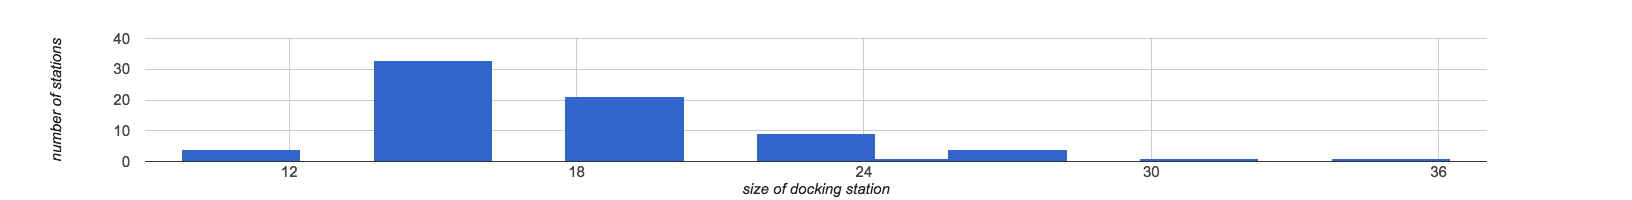

In [5]:
%chart columns --data count_of_docking_sizes --fields dockcount,cs
{
  "legend":{"position":"none"},
  "vAxis": {
    "title":"number of stations"
  },
  "hAxis": {
    "title": "size of docking station"
  }
}

It seems that medium size docking stations have a reasonable chance of having a lack of availability. This is because most docking stations have a capacity of 15. This may mean that the dockcount property is not a reliable marker of availability.

In [2]:
%%bq query --name location_and_availability

select
  sum(not_available) as not_available,
  stations.landmark
FROM `bigquery-public-data.san_francisco.bikeshare_stations` stations 
JOIN (
select 
   station_id,
  sum(if(bikes_available < 2, 1, 0)) as not_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
group by station_id
) status on stations.station_id = status.station_id
group by stations.landmark

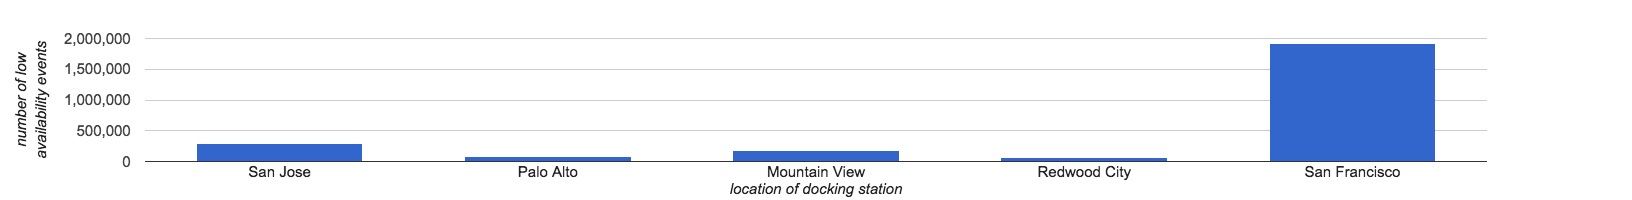

In [3]:
%chart columns --data location_and_availability --fields landmark,not_available
{
  "legend":{"position":"none"},
  "vAxis": {
    "title":"number of low availability events"
  },
  "hAxis": {
    "title": "location of docking station"
  }
}

Almost all of the lack of availability comes from docking stations in San Francisco, good news if you are in Mountain View and need a city hire bike.
Onto building a model. We will include hour, latitude and longitude, dockcount, region name, and a binary indicator of availability. 
How much data should we include?

In [3]:
%%bq query

SELECT 
  count(*) as count_records
FROM `bigquery-public-data.san_francisco.bikeshare_status` status

f0_
107501619


Yowza, 100 million records. We almost definitely don't need all of those, and we'd need a larger machine than this notebook is running on to comfortably handle them. Let's check the balance of this dataset to set out a sampling strategy.

In [2]:
%%bq query
select if(status.bikes_available < 2, 1, 0) as low_availability, count(*) as count_records
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
group by low_availability

low_availability,f0_
0,104975676
1,2525943


OK, so around 2% of our data is "low availability". We don't want to lose our signal. Let's rebalance these data.

We'll use a good trick on BigQuery, RAND() < sample fraction, to randomly sample the dataset before pulling data out of BigQuery.

In [51]:
low_class_count = 100000
high_class_count = 100000
q = bq.Query("""
SELECT 
  hour,
  latitude,
  longitude,
  dockcount,
  in_sf,
  in_sj,
  in_rc,
  in_mv,
  in_pa,
  low_availability
FROM (
SELECT 
    extract(hour from time) as hour
  , extract(dayofweek from time) as dow
  , stations.latitude
  , stations.longitude
  , stations.dockcount
  , if(stations.landmark = 'San Francisco', 1, 0) as in_sf
  , if(stations.landmark = 'San Jose', 1, 0) as in_sj
  , if(stations.landmark = 'Redwood City', 1, 0) as in_rc
  , if(stations.landmark = 'Mountain View', 1, 0) as in_mv
  , if(stations.landmark = 'Palo Alto', 1, 0) as in_pa
  , if(status.bikes_available < 2, 1, 0) as low_availability
FROM `bigquery-public-data.san_francisco.bikeshare_stations` stations 
JOIN `bigquery-public-data.san_francisco.bikeshare_status` status on stations.station_id = status.station_id
) a
WHERE (low_availability = 1 AND RAND() < {}/104975676) OR (low_availability = 0 AND RAND() < {}/104975676)
""".format(low_class_count, high_class_count))
df = q.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head()

,hour,latitude,longitude,dockcount,in_sf,in_sj,in_rc,in_mv,in_pa,low_availability
0,0,37.333988,-121.894902,11,0,1,0,0,0,0
1,0,37.333988,-121.894902,11,0,1,0,0,0,0
2,0,37.333988,-121.894902,11,0,1,0,0,0,0
3,0,37.333988,-121.894902,11,0,1,0,0,0,0
4,0,37.333988,-121.894902,11,0,1,0,0,0,0


Now we have selected our data, let's train a model using the TensorFlow estimator API. This makes building a simple model more straightforward and adds out of the box functionality.

In [52]:
# split the data into test and train
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

target_column = 'low_availability'
y_test = df_test[target_column]
y_train = df_train[target_column]
df_train = df_train.drop(columns=[target_column])
df_test = df_test.drop(columns=[target_column])

# model parameters
batch_size = 128
num_epochs = 10
shuffle=True

# input functions
input_fn_train = tf.estimator.inputs.pandas_input_fn(
  df_train, y=y_train,
  batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, target_column=target_column
)

input_fn_test = tf.estimator.inputs.pandas_input_fn(
  df_test, y=y_test,
  batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, target_column=target_column
)

# feature columns to use as input
lat = tf.feature_column.numeric_column('latitude')
lon = tf.feature_column.numeric_column('longitude')
dc = tf.feature_column.numeric_column('dockcount')
dockc = tf.feature_column.bucketized_column(dc, boundaries=[11, 15, 19, 23, 25])
sf = tf.feature_column.categorical_column_with_vocabulary_list('in_sf', [0,1])
sj = tf.feature_column.categorical_column_with_vocabulary_list('in_sj', [0,1])
rc = tf.feature_column.categorical_column_with_vocabulary_list('in_rc', [0,1])
mv = tf.feature_column.categorical_column_with_vocabulary_list('in_mv', [0,1])
pa = tf.feature_column.categorical_column_with_vocabulary_list('in_pa', [0,1])
hour = tf.feature_column.categorical_column_with_vocabulary_list('hour', [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
dow = tf.feature_column.categorical_column_with_vocabulary_list('dow', [1, 2, 3, 4, 5, 6, 7])
base_columns = [lat, lon, dockc, sf, sj, rc, mv, pa, hour]

# model training and evaluation
model = tf.estimator.LinearClassifier(model_dir='/tmp/sfc_model', feature_columns=base_columns)
model.train(input_fn=input_fn_train)
results = model.evaluate(input_fn=input_fn_test)
for key in sorted(results):
  print('%s: %s' % (key, results[key]))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6189587810>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/sfc_model', '_save_summary_steps': 100}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6189587810>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/sfc_model', '_save_summary_steps': 100}


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/sfc_model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/sfc_model/model.ckpt.


INFO:tensorflow:loss = 88.72288, step = 1


INFO:tensorflow:loss = 88.72288, step = 1


INFO:tensorflow:global_step/sec: 196.274


INFO:tensorflow:global_step/sec: 196.274


INFO:tensorflow:loss = 24.610237, step = 101 (0.515 sec)


INFO:tensorflow:loss = 24.610237, step = 101 (0.515 sec)


INFO:tensorflow:global_step/sec: 251.638


INFO:tensorflow:global_step/sec: 251.638


INFO:tensorflow:loss = 10.851547, step = 201 (0.395 sec)


INFO:tensorflow:loss = 10.851547, step = 201 (0.395 sec)


INFO:tensorflow:global_step/sec: 246.225


INFO:tensorflow:global_step/sec: 246.225


INFO:tensorflow:loss = 117.18285, step = 301 (0.408 sec)


INFO:tensorflow:loss = 117.18285, step = 301 (0.408 sec)


INFO:tensorflow:global_step/sec: 263.077


INFO:tensorflow:global_step/sec: 263.077


INFO:tensorflow:loss = 6.543789, step = 401 (0.380 sec)


INFO:tensorflow:loss = 6.543789, step = 401 (0.380 sec)


INFO:tensorflow:global_step/sec: 252.345


INFO:tensorflow:global_step/sec: 252.345


INFO:tensorflow:loss = 1.1689285, step = 501 (0.395 sec)


INFO:tensorflow:loss = 1.1689285, step = 501 (0.395 sec)


INFO:tensorflow:global_step/sec: 230.139


INFO:tensorflow:global_step/sec: 230.139


INFO:tensorflow:loss = 25.521585, step = 601 (0.435 sec)


INFO:tensorflow:loss = 25.521585, step = 601 (0.435 sec)


INFO:tensorflow:global_step/sec: 204.308


INFO:tensorflow:global_step/sec: 204.308


INFO:tensorflow:loss = 5.380833, step = 701 (0.490 sec)


INFO:tensorflow:loss = 5.380833, step = 701 (0.490 sec)


INFO:tensorflow:global_step/sec: 234.98


INFO:tensorflow:global_step/sec: 234.98


INFO:tensorflow:loss = 6.3597503, step = 801 (0.429 sec)


INFO:tensorflow:loss = 6.3597503, step = 801 (0.429 sec)


INFO:tensorflow:global_step/sec: 217.651


INFO:tensorflow:global_step/sec: 217.651


INFO:tensorflow:loss = 10.658804, step = 901 (0.457 sec)


INFO:tensorflow:loss = 10.658804, step = 901 (0.457 sec)


INFO:tensorflow:global_step/sec: 212.756


INFO:tensorflow:global_step/sec: 212.756


INFO:tensorflow:loss = 1.2263172, step = 1001 (0.469 sec)


INFO:tensorflow:loss = 1.2263172, step = 1001 (0.469 sec)


INFO:tensorflow:global_step/sec: 209.541


INFO:tensorflow:global_step/sec: 209.541


INFO:tensorflow:loss = 5.544381, step = 1101 (0.477 sec)


INFO:tensorflow:loss = 5.544381, step = 1101 (0.477 sec)


INFO:tensorflow:global_step/sec: 245.548


INFO:tensorflow:global_step/sec: 245.548


INFO:tensorflow:loss = 6.263328, step = 1201 (0.406 sec)


INFO:tensorflow:loss = 6.263328, step = 1201 (0.406 sec)


INFO:tensorflow:global_step/sec: 210.978


INFO:tensorflow:global_step/sec: 210.978


INFO:tensorflow:loss = 9.022989, step = 1301 (0.474 sec)


INFO:tensorflow:loss = 9.022989, step = 1301 (0.474 sec)


INFO:tensorflow:global_step/sec: 205.294


INFO:tensorflow:global_step/sec: 205.294


INFO:tensorflow:loss = 16.952559, step = 1401 (0.488 sec)


INFO:tensorflow:loss = 16.952559, step = 1401 (0.488 sec)


INFO:tensorflow:global_step/sec: 209.839


INFO:tensorflow:global_step/sec: 209.839


INFO:tensorflow:loss = 9.437456, step = 1501 (0.476 sec)


INFO:tensorflow:loss = 9.437456, step = 1501 (0.476 sec)


INFO:tensorflow:global_step/sec: 206.948


INFO:tensorflow:global_step/sec: 206.948


INFO:tensorflow:loss = 15.517637, step = 1601 (0.485 sec)


INFO:tensorflow:loss = 15.517637, step = 1601 (0.485 sec)


INFO:tensorflow:global_step/sec: 206.293


INFO:tensorflow:global_step/sec: 206.293


INFO:tensorflow:loss = 9.506597, step = 1701 (0.483 sec)


INFO:tensorflow:loss = 9.506597, step = 1701 (0.483 sec)


INFO:tensorflow:global_step/sec: 221.513


INFO:tensorflow:global_step/sec: 221.513


INFO:tensorflow:loss = 14.112251, step = 1801 (0.451 sec)


INFO:tensorflow:loss = 14.112251, step = 1801 (0.451 sec)


INFO:tensorflow:global_step/sec: 208.053


INFO:tensorflow:global_step/sec: 208.053


INFO:tensorflow:loss = 19.72948, step = 1901 (0.482 sec)


INFO:tensorflow:loss = 19.72948, step = 1901 (0.482 sec)


INFO:tensorflow:global_step/sec: 206.96


INFO:tensorflow:global_step/sec: 206.96


INFO:tensorflow:loss = 21.48827, step = 2001 (0.482 sec)


INFO:tensorflow:loss = 21.48827, step = 2001 (0.482 sec)


INFO:tensorflow:global_step/sec: 207.792


INFO:tensorflow:global_step/sec: 207.792


INFO:tensorflow:loss = 5.0304427, step = 2101 (0.481 sec)


INFO:tensorflow:loss = 5.0304427, step = 2101 (0.481 sec)


INFO:tensorflow:global_step/sec: 206.322


INFO:tensorflow:global_step/sec: 206.322


INFO:tensorflow:loss = 18.868639, step = 2201 (0.485 sec)


INFO:tensorflow:loss = 18.868639, step = 2201 (0.485 sec)


INFO:tensorflow:global_step/sec: 201.026


INFO:tensorflow:global_step/sec: 201.026


INFO:tensorflow:loss = 13.169241, step = 2301 (0.498 sec)


INFO:tensorflow:loss = 13.169241, step = 2301 (0.498 sec)


INFO:tensorflow:global_step/sec: 221.25


INFO:tensorflow:global_step/sec: 221.25


INFO:tensorflow:loss = 10.361349, step = 2401 (0.456 sec)


INFO:tensorflow:loss = 10.361349, step = 2401 (0.456 sec)


INFO:tensorflow:global_step/sec: 201.461


INFO:tensorflow:global_step/sec: 201.461


INFO:tensorflow:loss = 9.446033, step = 2501 (0.493 sec)


INFO:tensorflow:loss = 9.446033, step = 2501 (0.493 sec)


INFO:tensorflow:global_step/sec: 210.521


INFO:tensorflow:global_step/sec: 210.521


INFO:tensorflow:loss = 6.078503, step = 2601 (0.475 sec)


INFO:tensorflow:loss = 6.078503, step = 2601 (0.475 sec)


INFO:tensorflow:global_step/sec: 239.39


INFO:tensorflow:global_step/sec: 239.39


INFO:tensorflow:loss = 9.494724, step = 2701 (0.417 sec)


INFO:tensorflow:loss = 9.494724, step = 2701 (0.417 sec)


INFO:tensorflow:global_step/sec: 236.709


INFO:tensorflow:global_step/sec: 236.709


INFO:tensorflow:loss = 11.731966, step = 2801 (0.422 sec)


INFO:tensorflow:loss = 11.731966, step = 2801 (0.422 sec)


INFO:tensorflow:global_step/sec: 218.09


INFO:tensorflow:global_step/sec: 218.09


INFO:tensorflow:loss = 18.521553, step = 2901 (0.462 sec)


INFO:tensorflow:loss = 18.521553, step = 2901 (0.462 sec)


INFO:tensorflow:global_step/sec: 209.219


INFO:tensorflow:global_step/sec: 209.219


INFO:tensorflow:loss = 34.190365, step = 3001 (0.475 sec)


INFO:tensorflow:loss = 34.190365, step = 3001 (0.475 sec)


INFO:tensorflow:global_step/sec: 254.148


INFO:tensorflow:global_step/sec: 254.148


INFO:tensorflow:loss = 5.42079, step = 3101 (0.397 sec)


INFO:tensorflow:loss = 5.42079, step = 3101 (0.397 sec)


INFO:tensorflow:global_step/sec: 212.113


INFO:tensorflow:global_step/sec: 212.113


INFO:tensorflow:loss = 6.2789297, step = 3201 (0.471 sec)


INFO:tensorflow:loss = 6.2789297, step = 3201 (0.471 sec)


INFO:tensorflow:global_step/sec: 233.717


INFO:tensorflow:global_step/sec: 233.717


INFO:tensorflow:loss = 15.392616, step = 3301 (0.424 sec)


INFO:tensorflow:loss = 15.392616, step = 3301 (0.424 sec)


INFO:tensorflow:global_step/sec: 214.441


INFO:tensorflow:global_step/sec: 214.441


INFO:tensorflow:loss = 9.755715, step = 3401 (0.467 sec)


INFO:tensorflow:loss = 9.755715, step = 3401 (0.467 sec)


INFO:tensorflow:global_step/sec: 204.511


INFO:tensorflow:global_step/sec: 204.511


INFO:tensorflow:loss = 24.246456, step = 3501 (0.491 sec)


INFO:tensorflow:loss = 24.246456, step = 3501 (0.491 sec)


INFO:tensorflow:global_step/sec: 211.311


INFO:tensorflow:global_step/sec: 211.311


INFO:tensorflow:loss = 6.645162, step = 3601 (0.473 sec)


INFO:tensorflow:loss = 6.645162, step = 3601 (0.473 sec)


INFO:tensorflow:global_step/sec: 231.067


INFO:tensorflow:global_step/sec: 231.067


INFO:tensorflow:loss = 6.5278306, step = 3701 (0.433 sec)


INFO:tensorflow:loss = 6.5278306, step = 3701 (0.433 sec)


INFO:tensorflow:global_step/sec: 215.125


INFO:tensorflow:global_step/sec: 215.125


INFO:tensorflow:loss = 15.401213, step = 3801 (0.464 sec)


INFO:tensorflow:loss = 15.401213, step = 3801 (0.464 sec)


INFO:tensorflow:global_step/sec: 206.735


INFO:tensorflow:global_step/sec: 206.735


INFO:tensorflow:loss = 17.11576, step = 3901 (0.484 sec)


INFO:tensorflow:loss = 17.11576, step = 3901 (0.484 sec)


INFO:tensorflow:global_step/sec: 208.938


INFO:tensorflow:global_step/sec: 208.938


INFO:tensorflow:loss = 23.46291, step = 4001 (0.477 sec)


INFO:tensorflow:loss = 23.46291, step = 4001 (0.477 sec)


INFO:tensorflow:global_step/sec: 205.17


INFO:tensorflow:global_step/sec: 205.17


INFO:tensorflow:loss = 19.463306, step = 4101 (0.488 sec)


INFO:tensorflow:loss = 19.463306, step = 4101 (0.488 sec)


INFO:tensorflow:global_step/sec: 224.045


INFO:tensorflow:global_step/sec: 224.045


INFO:tensorflow:loss = 9.722035, step = 4201 (0.452 sec)


INFO:tensorflow:loss = 9.722035, step = 4201 (0.452 sec)


INFO:tensorflow:global_step/sec: 209.412


INFO:tensorflow:global_step/sec: 209.412


INFO:tensorflow:loss = 17.394278, step = 4301 (0.474 sec)


INFO:tensorflow:loss = 17.394278, step = 4301 (0.474 sec)


INFO:tensorflow:global_step/sec: 214.151


INFO:tensorflow:global_step/sec: 214.151


INFO:tensorflow:loss = 12.760031, step = 4401 (0.466 sec)


INFO:tensorflow:loss = 12.760031, step = 4401 (0.466 sec)


INFO:tensorflow:global_step/sec: 201.488


INFO:tensorflow:global_step/sec: 201.488


INFO:tensorflow:loss = 4.8472004, step = 4501 (0.496 sec)


INFO:tensorflow:loss = 4.8472004, step = 4501 (0.496 sec)


INFO:tensorflow:global_step/sec: 237.179


INFO:tensorflow:global_step/sec: 237.179


INFO:tensorflow:loss = 14.879469, step = 4601 (0.425 sec)


INFO:tensorflow:loss = 14.879469, step = 4601 (0.425 sec)


INFO:tensorflow:global_step/sec: 209.728


INFO:tensorflow:global_step/sec: 209.728


INFO:tensorflow:loss = 17.778162, step = 4701 (0.475 sec)


INFO:tensorflow:loss = 17.778162, step = 4701 (0.475 sec)


INFO:tensorflow:global_step/sec: 208.832


INFO:tensorflow:global_step/sec: 208.832


INFO:tensorflow:loss = 26.01438, step = 4801 (0.478 sec)


INFO:tensorflow:loss = 26.01438, step = 4801 (0.478 sec)


INFO:tensorflow:global_step/sec: 210.3


INFO:tensorflow:global_step/sec: 210.3


INFO:tensorflow:loss = 13.092712, step = 4901 (0.476 sec)


INFO:tensorflow:loss = 13.092712, step = 4901 (0.476 sec)


INFO:tensorflow:global_step/sec: 236.953


INFO:tensorflow:global_step/sec: 236.953


INFO:tensorflow:loss = 17.099085, step = 5001 (0.422 sec)


INFO:tensorflow:loss = 17.099085, step = 5001 (0.422 sec)


INFO:tensorflow:global_step/sec: 223.663


INFO:tensorflow:global_step/sec: 223.663


INFO:tensorflow:loss = 17.5179, step = 5101 (0.448 sec)


INFO:tensorflow:loss = 17.5179, step = 5101 (0.448 sec)


INFO:tensorflow:global_step/sec: 208.076


INFO:tensorflow:global_step/sec: 208.076


INFO:tensorflow:loss = 6.6398144, step = 5201 (0.479 sec)


INFO:tensorflow:loss = 6.6398144, step = 5201 (0.479 sec)


INFO:tensorflow:global_step/sec: 210.271


INFO:tensorflow:global_step/sec: 210.271


INFO:tensorflow:loss = 6.3102264, step = 5301 (0.479 sec)


INFO:tensorflow:loss = 6.3102264, step = 5301 (0.479 sec)


INFO:tensorflow:global_step/sec: 218.744


INFO:tensorflow:global_step/sec: 218.744


INFO:tensorflow:loss = 6.8652706, step = 5401 (0.456 sec)


INFO:tensorflow:loss = 6.8652706, step = 5401 (0.456 sec)


INFO:tensorflow:global_step/sec: 234.493


INFO:tensorflow:global_step/sec: 234.493


INFO:tensorflow:loss = 10.574279, step = 5501 (0.427 sec)


INFO:tensorflow:loss = 10.574279, step = 5501 (0.427 sec)


INFO:tensorflow:global_step/sec: 210.802


INFO:tensorflow:global_step/sec: 210.802


INFO:tensorflow:loss = 6.3891673, step = 5601 (0.474 sec)


INFO:tensorflow:loss = 6.3891673, step = 5601 (0.474 sec)


INFO:tensorflow:global_step/sec: 214.135


INFO:tensorflow:global_step/sec: 214.135


INFO:tensorflow:loss = 12.511558, step = 5701 (0.467 sec)


INFO:tensorflow:loss = 12.511558, step = 5701 (0.467 sec)


INFO:tensorflow:global_step/sec: 238.886


INFO:tensorflow:global_step/sec: 238.886


INFO:tensorflow:loss = 9.918871, step = 5801 (0.417 sec)


INFO:tensorflow:loss = 9.918871, step = 5801 (0.417 sec)


INFO:tensorflow:global_step/sec: 258.044


INFO:tensorflow:global_step/sec: 258.044


INFO:tensorflow:loss = 7.3953824, step = 5901 (0.391 sec)


INFO:tensorflow:loss = 7.3953824, step = 5901 (0.391 sec)


INFO:tensorflow:global_step/sec: 211.244


INFO:tensorflow:global_step/sec: 211.244


INFO:tensorflow:loss = 6.273862, step = 6001 (0.471 sec)


INFO:tensorflow:loss = 6.273862, step = 6001 (0.471 sec)


INFO:tensorflow:global_step/sec: 202.795


INFO:tensorflow:global_step/sec: 202.795


INFO:tensorflow:loss = 18.113989, step = 6101 (0.496 sec)


INFO:tensorflow:loss = 18.113989, step = 6101 (0.496 sec)


INFO:tensorflow:global_step/sec: 219.244


INFO:tensorflow:global_step/sec: 219.244


INFO:tensorflow:loss = 11.3785925, step = 6201 (0.452 sec)


INFO:tensorflow:loss = 11.3785925, step = 6201 (0.452 sec)


INFO:tensorflow:global_step/sec: 215.463


INFO:tensorflow:global_step/sec: 215.463


INFO:tensorflow:loss = 9.855383, step = 6301 (0.464 sec)


INFO:tensorflow:loss = 9.855383, step = 6301 (0.464 sec)


INFO:tensorflow:global_step/sec: 206.823


INFO:tensorflow:global_step/sec: 206.823


INFO:tensorflow:loss = 31.567205, step = 6401 (0.484 sec)


INFO:tensorflow:loss = 31.567205, step = 6401 (0.484 sec)


INFO:tensorflow:Saving checkpoints for 6432 into /tmp/sfc_model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6432 into /tmp/sfc_model/model.ckpt.


INFO:tensorflow:Loss for final step: 4.309165.


INFO:tensorflow:Loss for final step: 4.309165.


INFO:tensorflow:Starting evaluation at 2018-04-12-01:03:04


INFO:tensorflow:Starting evaluation at 2018-04-12-01:03:04


INFO:tensorflow:Restoring parameters from /tmp/sfc_model/model.ckpt-6432


INFO:tensorflow:Restoring parameters from /tmp/sfc_model/model.ckpt-6432


INFO:tensorflow:Finished evaluation at 2018-04-12-01:03:14


INFO:tensorflow:Finished evaluation at 2018-04-12-01:03:14


INFO:tensorflow:Saving dict for global step 6432: accuracy = 0.9767758, accuracy_baseline = 0.9767758, auc = 0.6933974, auc_precision_recall = 0.063388176, average_loss = 0.1045431, global_step = 6432, label/mean = 0.023224177, loss = 13.381256, prediction/mean = 0.021453679


INFO:tensorflow:Saving dict for global step 6432: accuracy = 0.9767758, accuracy_baseline = 0.9767758, auc = 0.6933974, auc_precision_recall = 0.063388176, average_loss = 0.1045431, global_step = 6432, label/mean = 0.023224177, loss = 13.381256, prediction/mean = 0.021453679


accuracy: 0.9767758
accuracy_baseline: 0.9767758
auc: 0.6933974
auc_precision_recall: 0.063388176
average_loss: 0.1045431
global_step: 6432
label/mean: 0.023224177
loss: 13.381256
prediction/mean: 0.021453679


This model is ok, AUC varying between 0.6 and 0.8 depending on the sample. High accuracy. 

I am interesting in expanding this to be able to predict if a specific station is going to have capacity in n time steps. This could power a service where I can be told what the chances are that the bike I'm hoping to get will be gone by the time I get there - this would have been incredibly useful on my last visit to NYC.

To start with, let's check the frequency of status updates.

In [1]:
%%bq query

select min(sd) as min_td, avg(sd) as mean_td, max(sd) as max_td, count(*) as num_records from (
SELECT  
timestamp_diff( lead(time) 
over(partition by station_id 
order by time asc
), time, SECOND) as sd
FROM `bigquery-public-data.san_francisco.bikeshare_status` 
) a

f0_,f1_,f2_,f3_
51,60.9163333133,2985300,107501619


Right so oftentimes, the station sends a status every minute. Let's pull data for a specific station and get started with predicting availability. I'm going to use LEAD(), an analytical function from BigQuery, to pull out a future record for the query station. I'm also preparing two columns for labels, which is how TensorFlow likes to consume target values.

In [ ]:
# the station_id is a global variable. If it is changed, the data extraction and model training should be rerun.
station_id = 91

In [16]:
q = bq.Query(
"""
SELECT
  bikes_available,
  IF(next_ba <= 2,
    1,
    0) AS low_availability,
  IF(next_ba > 2,
    1,
    0) AS high_availability  
FROM (
  SELECT
    time,
    bikes_available,
    LEAD(bikes_available, 30) OVER(PARTITION BY station_id ORDER BY time ASC ) AS next_ba
  FROM
    `bigquery-public-data.san_francisco.bikeshare_status`
  WHERE
    station_id = {}
  ORDER BY
    time ASC ) a
WHERE
  next_ba IS NOT NULL
""".format(station_id)
)
df = q.execute(output_options=bq.QueryOutput.dataframe()).result()

# we need to massage the data to pass it to a model as a time series
as_strided = np.lib.stride_tricks.as_strided  
win = 15 # collect data for next 15 steps
v = as_strided(df.bikes_available, (len(df) - (win - 1), win), (df.bikes_available.values.strides * 2))
df['strides'] = pd.Series(v.tolist())
df = df[df.strides.notnull()]  # If nulls are not filtered out, TensorFlow throws really strange exceptions

# test/train split
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

We need an iterator for the DataFrame to allow random batches out of the container.

In [19]:
# reference: https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.iloc[self.cursor:self.cursor+n]
        self.cursor += n
        x = np.expand_dims(np.array(res['strides'].tolist()), axis=1)
        y = res[['low_availability', 'high_availability']].as_matrix()
        return x, y

Let's define a TensorFlow graph, that part which holds the directions for data and weights moving around the model.

In [108]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
training_steps = 2000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 15
timesteps = 1
num_hidden = 128 # hidden layer num of features
num_classes = 2

# tf Graph input
X = tf.placeholder("float32", [None, timesteps, num_input])
Y = tf.placeholder("float32", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}
  
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
  
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

Once we have prepared data and a defined graph, we work with a Session object to learn weights for the graph.

In [ ]:
# Generate iterators - in this block to avoid issues with iterator reuse      
train_itr = SimpleDataIterator(train)
test_itr = SimpleDataIterator(test)

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = train_itr.next_batch(batch_size)
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            print("****** in loss op *****")
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")
    
    test_x, test_y = test_itr.next_batch(len(test))
    
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_x, Y: test_y}))
    
    save_path = saver.save(sess, "/tmp/model_{}.ckpt".format(station_id))

We have a fantastic time series model for one station. We should generalise this for multiple stations. Logically that isn't hard, however TensorFlow doesn't allow us to have multiple models in one session. In pseudocode, what we'd do is this:
```
accuracy = {}
models = {}

for station_id in station_ids:
  train, test = get_data(station_id)
  model = train_model(train)
  acc = test_model(model)
  accuracy[station_id] = acc
  models[station_id] = model
  
def query(station_id):
  model = models[station_id]
  recent_data = get_recent_data(station_id)
  pred = model.predict(recent_data)
  return pred
```  
With other libraries, this would be a little easier to quickly code up a demo of. We start by parameterising the data pulling and the session training.

In [113]:
def pull_data(s_id):
  q = bq.Query(
  """
  SELECT
    bikes_available,
    IF(next_ba <= 2,
      1,
      0) AS low_availability,
    IF(next_ba > 2,
      1,
      0) AS high_availability  
  FROM (
    SELECT
      time,
      bikes_available,
      LEAD(bikes_available, 30) OVER(PARTITION BY station_id ORDER BY time ASC ) AS next_ba
    FROM
      `bigquery-public-data.san_francisco.bikeshare_status`
    WHERE
      station_id = {}
    ORDER BY
      time ASC ) a
  WHERE
    next_ba IS NOT NULL
  """.format(s_id)
  )
  df = q.execute(output_options=bq.QueryOutput.dataframe()).result()

  # we need to massage the data to pass it to a model as a time series
  as_strided = np.lib.stride_tricks.as_strided  
  win = 15 # collect data for next 15 steps
  v = as_strided(df.bikes_available, (len(df) - (win - 1), win), (df.bikes_available.values.strides * 2))
  df['strides'] = pd.Series(v.tolist())
  df = df[df.strides.notnull()]
  msk = np.random.rand(len(df)) < 0.8
  train = df[msk]
  test = df[~msk]
  return train, test

We next parameterise the session learning, allowing us to save the accuracy for each station's model as well as writing out each set of weights to disk.

In [116]:
saver = tf.train.Saver()

def train_session(s_id):
  print("*****")
  print("Training for station {}.".format(s_id))
  print("*****")
  print("pulling data...")
  train, test = pull_data(s_id)
  print("data fetched.")
  train_itr = SimpleDataIterator(train)
  test_itr = SimpleDataIterator(test)
  
  # Start training
  with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    print("Training model for station {}.".format(s_id))

    for step in range(1, training_steps+1):
        batch_x, batch_y = train_itr.next_batch(batch_size)
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            print("****** in loss op *****")
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")
    
    test_x, test_y = test_itr.next_batch(len(test))
    session_accuracy = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    print("Testing Accuracy:", session_accuracy)
    
    save_path = saver.save(sess, "/tmp/model_{}.ckpt".format(s_id))
    
    return session_accuracy

Finally, we loop over the station IDs and learn weights for the graph for this station.

In [119]:
def stations_train():
  client = bigquery.Client()
  query_job = client.query(
     """
     SELECT DISTINCT station_id
     FROM `bigquery-public-data.san_francisco.bikeshare_stations`
     """
  )
  results = query_job.result()
  accuracy_store = {}
  for row in results:
    s_id = row.station_id
    accuracy_store[s_id] = train_session(s_id)
    
  return accuracy_store

Now, training a bunch of deep neural networks is as simple as:

In [ ]:
accuracy_store = stations_train()  # this will take some time

*****
Training for 4.
*****
****** in loss op *****
Step 1, Minibatch Loss= 0.2845, Training Accuracy= 0.969
****** in loss op *****
Step 200, Minibatch Loss= 0.0988, Training Accuracy= 0.922
****** in loss op *****
Step 400, Minibatch Loss= 0.1263, Training Accuracy= 0.977
****** in loss op *****
Step 600, Minibatch Loss= 0.1175, Training Accuracy= 0.984
****** in loss op *****
Step 800, Minibatch Loss= 0.0834, Training Accuracy= 0.984
****** in loss op *****
Step 1000, Minibatch Loss= 0.0485, Training Accuracy= 0.984
****** in loss op *****
Step 1200, Minibatch Loss= 0.0909, Training Accuracy= 0.969
****** in loss op *****
Step 1400, Minibatch Loss= 0.0542, Training Accuracy= 0.992
****** in loss op *****
Step 1600, Minibatch Loss= 0.1742, Training Accuracy= 0.977
****** in loss op *****
Step 1800, Minibatch Loss= 0.0520, Training Accuracy= 0.984
****** in loss op *****
Step 2000, Minibatch Loss= 0.0669, Training Accuracy= 0.992
****** in loss op *****
Step 2200, Minibatch Loss= 0.07

In [ ]:
for k, v in accuracy_store.iteritems():
  print("Accuracy for station {}: {}.".format(k, v))

To simulate an online lookup, we need to be able to fetch 15 consecutive samples for a station ID. In the real world, we'd simply pull the most recent status updates. In this code block, we're simulating that by setting a random time window and reshaping that data such at TensorFlow will work with it.

In [100]:
date_format = '%Y-%m-%d %H:%M:%S'

def station_time_range(s_id):
  client = bigquery.Client()
  query_job = client.query(
     """
     SELECT min(time) as start_ts, max(time) as end_ts
     FROM `bigquery-public-data.san_francisco.bikeshare_status`
     WHERE
       station_id = {}
     """.format(s_id)
  )
  results = query_job.result()
  for row in results:
    return row.start_ts, row.end_ts

def date_range_pair(start_date, end_date):
  delta = end_date - start_date
  int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
  random_second = randrange(int_delta)
  start_dt = start_date + timedelta(seconds=random_second)
  end_dt = start_dt + timedelta(minutes=20)
  return start_dt, end_dt

def pull_data(s_id):
  min_date, max_date = station_time_range(s_id)
  start_dt, end_dt = date_range_pair(min_date, max_date - timedelta(minutes=2))

  client = bigquery.Client()
  query_job = client.query(
  """
  SELECT
    bikes_available
  FROM
    `bigquery-public-data.san_francisco.bikeshare_status`
  WHERE
    station_id = {}
    AND time between '{}' and '{}'
  ORDER BY
    time ASC 
  LIMIT 15
  """.format(s_id, datetime.strftime(start_dt, date_format), datetime.strftime(end_dt, date_format))
  )
  results = query_job.result()
  xs = []
  for row in results:
    xs.append(row.bikes_available)
    
  return np.expand_dims(np.expand_dims(np.array(xs), axis=0), axis=0)

We now have a way to simulate getting 15 recent status updates for the station we're working on. To make predictions online with the trained model, we need to restore the model from disk and query the model. With extra effort, the sessions for each trained model could be stored in a map to avoid initialising a model for each call. This would be useful if we had one backend server in a REST API which would be queried with the station ID.

In [112]:
def do_prediction(s_id):
  with tf.Session() as sess:
    saver.restore(sess, "/tmp/model_{}.ckpt".format(s_id))
    preds = sess.run(prediction, {X: pull_data(s_id)})
    print(preds)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


[[8.3232475e-12 1.0000000e+00]]


In [ ]:
do_prediction(91)